# Quick example

Generating peaks with Spectra and fitting them with JuMP V0.19 or higher

Charles Le Losq, May 2017; Updated 2019

In [1]:
# using Spectra, and pyplot for plotting stuffs
using PyPlot, Spectra

# for peak fitting:
using JuMP, Ipopt

# for Bayesian peak fitting:
using Turing

# we can also use Optim for simple problem (check if you have it installed)
using Optim

- Generating the x values

In [2]:
x = collect(0:0.1:100);

- Two Gaussian peaks

We can generate the two gaussians one after the other. In this case, do not forget to provide values in arrays for the gaussiennes function, even for a single peak.

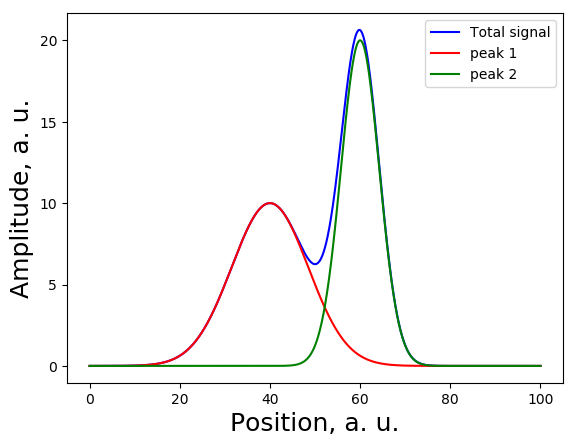

PyObject <matplotlib.legend.Legend object at 0x7f30d2b57320>

In [3]:
amplitude_1 = 10.;
amplitude_2 = 20.;

position_1 = 40.;
position_2 = 60.;

halfwidth_1 = 10.;
halfwidth_2 = 5.;

y1, y_peak1 = gaussiennes([amplitude_1],[position_1],[halfwidth_1],x) # in this case y1 == y_peak1
y2, y_peak2 = gaussiennes([amplitude_2],[position_2],[halfwidth_2],x) # in this case y1 == y_peak1

figure()
plot(x,y1+y2,"b-",label="Total signal")# the bulk signal
plot(x,y1,"r-",label="peak 1") 
plot(x,y2,"g-",label="peak 2") 
xlabel("Position, a. u.",fontname="Sans",fontsize = 18)
ylabel("Amplitude, a. u.", fontname = "Sans", fontsize = 18)
legend()

- Another option is to use the ability of gaussiennes to handle arrays. In this case, y_peaks will be a 2 columns array containing the two peak signals.

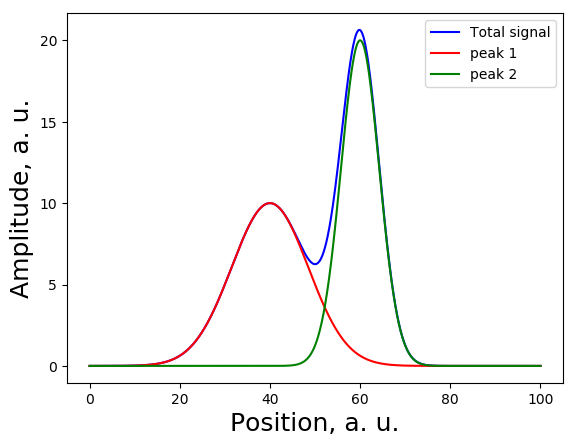

PyObject <matplotlib.legend.Legend object at 0x7f30d2a7b8d0>

In [4]:
y_tot, y_peaks = gaussiennes([amplitude_1;amplitude_2],[position_1;position_2],[halfwidth_1;halfwidth_2],x)

figure()
plot(x,y_tot,"b-",label="Total signal")# the bulk signal
plot(x,y_peaks[:,1],"r-",label="peak 1") 
plot(x,y_peaks[:,2],"g-",label="peak 2") 
xlabel("Position, a. u.",fontname="Sans",fontsize = 18)
ylabel("Amplitude, a. u.", fontname = "Sans", fontsize = 18)
legend()

- Now let's add some noise to this signal, and try to fit it.

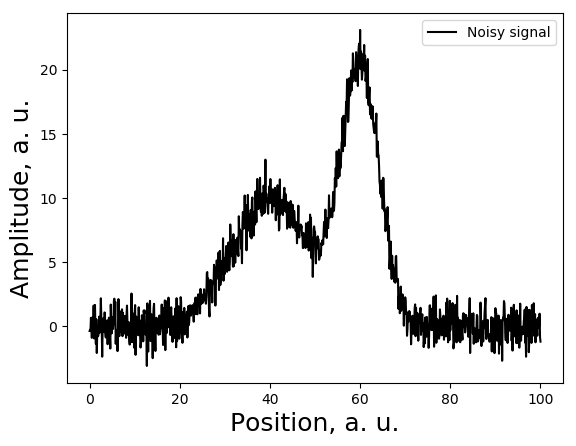

PyObject <matplotlib.legend.Legend object at 0x7f30d2a6a550>

In [5]:
y_noisy = y_tot + randn(size(y_tot,1))
figure()
plot(x,y_noisy,"k-",label="Noisy signal")
xlabel("Position, a. u.",fontname="Sans",fontsize = 18)
ylabel("Amplitude, a. u.", fontname = "Sans", fontsize = 18)
legend()

- We create a JuMP model and will solve the problem with Ipopt

In [6]:
nb_peaks = 2 # number of expected peaks
nb_points = size(x,1) # number of data points in the spectrum

# we guess the starting values, not very well...
amp_guess = [5.;25.]
pos_guess = [35.;70.]
hw_guess = [10.;25.]

model_ = Model(with_optimizer(Ipopt.Optimizer))

# we define the variables with bounds; see documentation of JuMP for details, many things possible!
@variable(model_,0. <= amp[i=1:2] <= 50.,start=amp_guess[i])
@variable(model_,20. <=pos[i=1:2] <= 80.,start=pos_guess[i])
@variable(model_,0. <= hw[i=1:2]  <= 80.,start=hw_guess[i])

# we create an array of gaussian peaks; do not forget that you need to perform point to point calculation
# we cannot use the gaussiennes function there
@NLexpression(model_,gauss[j=1:nb_points,i=1:nb_peaks], amp[i]*exp(-log(2) *((x[j] - pos[i])/hw[i])^2))

@NLobjective(model_, Min,sum((sum(gauss[j,i] for i = 1:nb_peaks)-y_noisy[j])^2 for j =1:nb_points))
optimize!(model_) # solving the model
      
# getting the best parameters
best_amp = value.(amp)
best_pos = value.(pos)
best_hw = value.(hw);

# calculating the model
y_calc, peaks_calc = gaussiennes(best_amp,best_pos,best_hw,x);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       21

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equ

In [7]:
println("Parameters calculated by JuMP + Ipopt algo are")
println("Amplitudes: $(best_amp)")
println("Positions: $(best_pos)")
println("Half-Width: $(best_hw)")

Parameters calculated by JuMP + Ipopt algo are
Amplitudes: [9.91182, 20.034]
Positions: [40.1708, 60.0492]
Half-Width: [10.0435, 4.97265]


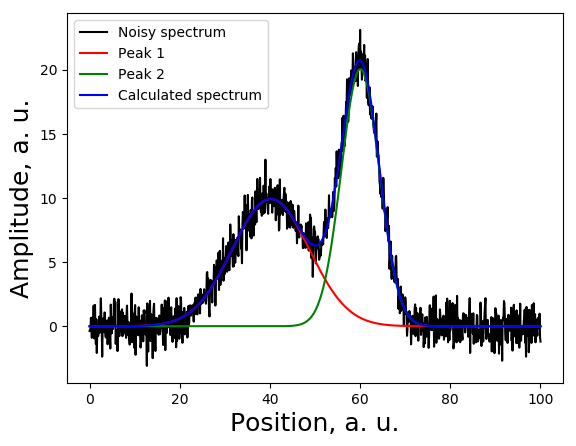

PyObject <matplotlib.legend.Legend object at 0x7f30d2084c88>

In [8]:
figure()
plot(x,y_noisy,"k-",label="Noisy spectrum")
plot(x,peaks_calc[:,1],"r-",label="Peak 1")
plot(x,peaks_calc[:,2],"g-",label="Peak 2")
plot(x,y_calc,"b-",label="Calculated spectrum")

xlabel("Position, a. u.",fontname="Sans",fontsize = 18)
ylabel("Amplitude, a. u.", fontname = "Sans", fontsize = 18)
legend()

- You could also use the LsqFit to fit such an easy case. Here's the way to do it:

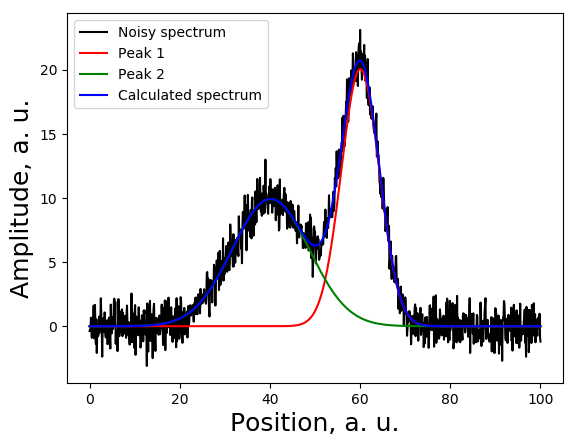

Parameters calculated by Optim (Nelder-Mead algo) are
Amplitudes: [20.034, 9.91183]
Positions: [60.0492, 40.1708]
Half-Width: [4.97266, 10.0434]


In [9]:
# this funciton will use gaussiennes to construct the model
function model_test(x,p)
    amp = p[1:2]
    pos = p[3:4]
    hw  = p[5:6]
    y, peaks = gaussiennes(amp,pos,hw,x)
    return vec(y)
end

# you define an anonymous function as the pobjective function
objective_function(p) = sum((y_noisy .- model_test(x,p)).^2) # a least square objective function

p0 = [10.;10.;40;50;5.;5.]
Optim_model = Optim.optimize(objective_function,p0,NelderMead())

# getting the best parameters
best_param = Optim.minimizer(Optim_model)

# calculating the model
y_calc_2, peaks_calc_2 = gaussiennes(best_param[1:2],best_param[3:4],best_param[5:6],x)

figure()
plot(x,y_noisy,"k-",label="Noisy spectrum")
plot(x,peaks_calc_2[:,1],"r-",label="Peak 1")
plot(x,peaks_calc_2[:,2],"g-",label="Peak 2")
plot(x,y_calc_2,"b-",label="Calculated spectrum")

xlabel("Position, a. u.",fontname="Sans",fontsize = 18)
ylabel("Amplitude, a. u.", fontname = "Sans", fontsize = 18)
legend()

println("Parameters calculated by Optim (Nelder-Mead algo) are")
println("Amplitudes: $(best_param[1:2])")
println("Positions: $(best_param[3:4])")
println("Half-Width: $(best_param[5:6])")

- We note one bad thing: Optim can return a negative value for one of the half-width... In general, JuMP + Ipopt give very good result and a very high level of control. The drawback is that you have to write down the equations by yourself. On the good side: automatic differentiation is performed...